In [1]:
!pip3 install pyabc==0.10.10

In [1]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: __MACOSX/._data         
  inflating: data/TMZ3.csv           
  inflating: __MACOSX/data/._TMZ3.csv  
  inflating: data/TMZ2.csv           
  inflating: __MACOSX/data/._TMZ2.csv  
  inflating: data/TMZ1.csv           
  inflating: __MACOSX/data/._TMZ1.csv  
  inflating: data/playlists.csv      
  inflating: __MACOSX/data/._playlists.csv  
  inflating: data/PCV1.csv           
  inflating: __MACOSX/data/._PCV1.csv  
  inflating: data/PCV2.csv           
  inflating: __MACOSX/data/._PCV2.csv  
  inflating: data/PCV3.csv           
  inflating: __MACOSX/data/._PCV3.csv  
  inflating: data/RT1.csv            
  inflating: __MACOSX/data/._RT1.csv  
  inflating: data/RT2.csv            
  inflating: __MACOSX/data/._RT2.csv  
  inflating: data/RT3.csv            
  inflating: __MACOSX/data/._RT3.csv  


In [109]:
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import pandas as pd
import numpy as np
import scipy as sp
import os
import tempfile

from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition)
from pyabc.sampler import SingleCoreSampler

import TumorPatientData as TPD

from functools import partial
import multiprocessing
import time

from termcolor import colored

In [3]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "tumor.db"))

In [4]:
MTD2Sphere = False
data = TPD.load_data(MTD2Sphere)

In [5]:
data_fig = TPD.make_plot(data, MTD2Sphere)
data_fig.show()

## Data groups
* 0-2: PCV
* 2-5: TMZ
* 6-8: RT

In [6]:
data[0]

,0,1,2,3,4,5,6,7,8,9
0,-84.159159,34.509202,-77.277277,33.231084,-73.853715,31.550595,-10.856690,47.675008,-14.332388,34.213342
1,-43.493493,40.047716,-40.617353,35.988506,-69.943555,32.881968,5.652875,44.420539,-12.811770,36.580228
2,-31.606607,43.456033,-3.688063,46.195704,-63.209390,36.876089,16.514431,41.166070,-8.684379,38.207462
3,-24.099099,47.290389,6.304568,40.426418,-49.741061,40.130557,28.027680,45.456052,-2.819139,41.905722
4,-12.212212,54.959100,20.859053,33.029899,-37.358887,42.201583,33.892921,48.414660,0.222097,40.574349
5,-4.704705,56.663258,33.023996,30.367151,-15.201312,48.858451,NaN,NaN,3.915026,39.242975
6,3.741241,53.254942,47.578481,29.479569,-6.077605,49.450172,NaN,NaN,10.431960,39.390905
7,7.807808,46.225290,57.353882,33.473690,3.915026,48.266729,NaN,NaN,21.945209,43.385026
8,21.571572,38.343558,69.736055,32.586107,10.214729,43.532957,NaN,NaN,27.593218,40.278488
9,33.458458,36.426380,81.032074,32.881968,16.948893,44.124678,NaN,NaN,35.196307,42.497444


# Model
<img src="ODE_cycle.jpg" width="600">

## Czynniki
**P** - proliferative tissue, tumor tissue <br>
rozrastająca się tkanka rakowa

**Q** - non-proliferative tissue <br>
tkanka rakowa wyciszona

**QP** - DNA-damaged Q tissue by the drug impact <br>
tkanka rakowa wyciszona z uszkodzonym DNA

**C** - drug concentration <br>
obecna ilość leku w organiźmie (max 1)


## Parametry
**KDE** - constant rate of the decay of the drug concentration <br>
tempo zanikania wpływu leku

**lambda_P** - growth rate of P

**gamma_P** - damages in P tissue caused by the drug

**gamma_Q** - damages in Q tissue caused by the drug <br>
autorzy zakładają: gamma_P = gamma_Q

**k_QP_P** - constant rate of transfer from QP to P tissue 

**delta_QP** - constant rate of elimination of QP tissue

**k_P_Q** - constant rate of transfer from P to Q tissue

**K** - maximal tumor size

# Individual Model

In [7]:
def individual_eq(t, y, KDE, lambda_P, gamma_P, gamma_Q, k_QP_P, delta_QP, k_P_Q, K, t_rise):
    P_sum, C, P, Q, QP = y
    
    if t < -t_rise:
        dC = 0
        C = 0
    elif -t_rise <= t < 0:
        dC = 1/t_rise
    else:
        dC = -KDE * C
    
    dP = lambda_P * P * (1 - P_sum/K) + k_QP_P * QP - k_P_Q * P - gamma_P * C * KDE * P
    dQ = k_P_Q * P - gamma_Q * C * KDE * Q
    dQP = gamma_Q * C * KDE * Q - k_QP_P * QP - delta_QP * QP

    dP_sum = dP+ dQ + dQP

    return dP_sum, dC, dP, dQ, dQP

In [87]:
def individual_model(t, y0, pars):
    t_rise =  (t[-1] - t[0])/20
    t_rise_up = min(t_rise, t[-1])
    t_rise_down = max(-t_rise, t[0])
    t_eval = np.unique(np.hstack([np.linspace(t[0], t[-1], 1000), np.linspace(t_rise_down, t_rise_up, 100), t]))
    sol = sp.integrate.solve_ivp(fun=individual_eq, 
                                 t_span=(t[0], t[-1]),
                                 t_eval=t_eval, 
                                 y0=y0,
                                 args=(
                                    pars["KDE"], pars["lambda_P"], pars["gamma_P"],
                                    pars["gamma_Q"], pars["k_QP_P"], pars["delta_QP"],
                                    pars["k_P_Q"], pars["K"], t_rise
                                 ),
#                                 method="BDF",
#                                 atol=1e-5
                                )
    return {"P_sum": sol.y[0, :], "dC": sol.y[1, :], "t": sol.t}

## PCV

In [88]:
KDE_art = 0.1
lambda_P_art = 0.121
gamma_P_art = 0.3
gamma_Q_art = gamma_P_art
k_QP_P_art = 0.05
delta_QP_art = 0.01
k_P_Q_art = 0.1
K_art = 100

In [89]:
group_n = 0  #groups for PCV: 0, 1, 2
# patient_n = 1
patient_n = 2

PCV_ind_patient_data = np.array(data[group_n][patient_n*2+1][data[group_n][patient_n*2+1].notnull()])
PCV_ind_patient_time = data[group_n][patient_n*2][data[group_n][patient_n*2].notnull()]
PCV_ind_patient_time = np.array([round(t) for t in PCV_ind_patient_time])

In [90]:
P_SUM_0 = PCV_ind_patient_data[0]
C_0 = 0
QP_0 = 0
P_0 = P_SUM_0 / 5
Q_0 = P_SUM_0 - P_0 - QP_0

In [91]:
PCV_art_ind_y0 = np.array([P_SUM_0, C_0, P_0, Q_0, QP_0])
PCV_art_ind_model = individual_model(pars={
    "KDE": KDE_art,
    "lambda_P": lambda_P_art,
    "gamma_P": gamma_P_art, 
    "gamma_Q": gamma_Q_art,
    "k_QP_P": k_QP_P_art,
    "delta_QP": delta_QP_art,
    "k_P_Q": k_P_Q_art,
    "K": K_art},
    t=PCV_ind_patient_time,
    y0=PCV_art_ind_y0
)

In [92]:
PCV_art_ind_model

{'P_sum': array([31.55059456, 31.6007572 , 31.65080015, ..., 48.84985054,
        48.86934726, 48.88889812]),
 'dC': array([0.        , 0.        , 0.        , ..., 0.09829543, 0.09735553,
        0.09642452]),
 't': array([-74.        , -73.9039039 , -73.80780781, ...,  21.80780781,
         21.9039039 ,  22.        ])}

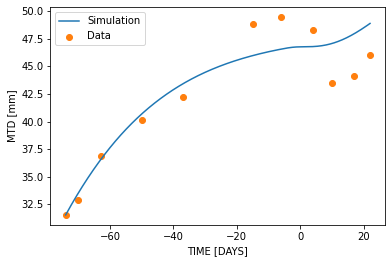

In [93]:
plt.plot(PCV_art_ind_model['t'], PCV_art_ind_model['P_sum'], color="C0", label='Simulation')
plt.scatter(PCV_ind_patient_time, PCV_ind_patient_data, color="C1", label='Data')
plt.xlabel("TIME [DAYS]")
plt.ylabel("MTD [mm]")
plt.legend()
plt.show()

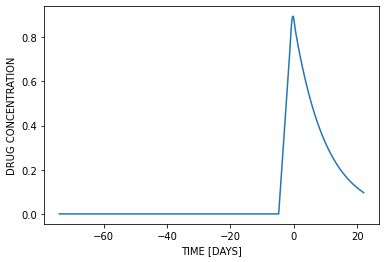

In [94]:
plt.plot(PCV_art_ind_model['t'], PCV_art_ind_model['dC'], color="C0", label='Simulation')
plt.xlabel("TIME [DAYS]")
plt.ylabel("DRUG CONCENTRATION")
plt.show()

### Asymilacja modelu indywidualnego do wybranego pacjenta



In [112]:
def get_simulation_time_indices(simulation_t, data_t):
    indices = []
    for t in data_t:
        found = np.where(simulation_t == t)[0]
        if found.shape[0] > 0:
            found = found[0]
            indices.append(found)
    return indices


def distance(simulation, measurement):
    simulation_t = simulation['t']
    measurement_t = measurement['t']
    
    sim_ind = get_simulation_time_indices(simulation_t, measurement_t)
    
    simulation_t = np.take(simulation_t, sim_ind)
    if simulation_t.shape != measurement_t.shape:
        print("simulation and measurement times shapes unequal")

    measurement_data = measurement['P_sum']
    simulation_data = np.take(simulation['P_sum'], sim_ind)

    #L1
    # diff = np.abs(simulation_data - measurement_data)

    #L2
    diff = np.sqrt(np.square(simulation_data - measurement_data))

    dist = np.mean(diff)
    return dist


def get_posterior(history):
    return history.get_distribution()[0].tail(1).values[0]

def show_art_abc_posterior(history):
    (K_ind_abc, KDE_ind_abc,
    delta_QP_ind_abc, gamma_P_ind_abc, 
    gamma_Q_ind_abc, k_P_Q_ind_abc, 
    k_QP_P_ind_abc, lambda_P_ind_abc) = get_posterior(h)
    
    print(
    f"""
    \t\tARTICLE: \t ABC-SMC
    K: \t\t {K_art} \t\t {K_ind_abc}
    KDE: \t {KDE_art} \t\t {KDE_ind_abc}
    delta_QP: \t {delta_QP_art} \t\t {delta_QP_ind_abc}
    gamma_P: \t {gamma_P_art} \t\t {gamma_P_ind_abc}
    gamma_Q: \t {gamma_Q_art} \t\t {gamma_Q_ind_abc}
    k_P_Q: \t {k_P_Q_art} \t\t {k_P_Q_ind_abc}
    k_QP_P: \t {k_QP_P_art} \t\t {k_QP_P_ind_abc}
    lambda_P: \t {lambda_P_art} \t\t {lambda_P_ind_abc}
    """)

def show_article_comparison(art, abc, group_name):
    (K_abc, KDE_abc,
    delta_QP_abc, gamma_P_abc, 
    gamma_Q_abc, k_P_Q_abc, 
    k_QP_P_abc, lambda_P_abc) = abc

    (K_art, KDE_art,
    delta_QP_art, gamma_P_art, 
    gamma_Q_art, k_P_Q_art, 
    k_QP_P_art, lambda_P_art) = art

    print(
    f"""
    \tGROUP: {colored(group_name,attrs=['bold'])}

    \t\tARTICLE: \t ABC-SMC
    K: \t\t {K_art} \t\t {K_abc}
    KDE: \t {KDE_art} \t\t {KDE_abc}
    delta_QP: \t {delta_QP_art} \t\t {delta_QP_abc}
    gamma_P: \t {gamma_P_art} \t\t {gamma_P_abc}
    gamma_Q: \t {gamma_Q_art} \t\t {gamma_Q_abc}
    k_P_Q: \t {k_P_Q_art} \t\t {k_P_Q_abc}
    k_QP_P: \t {k_QP_P_art} \t\t {k_QP_P_abc}
    lambda_P: \t {lambda_P_art} \t\t {lambda_P_abc}
    """)

In [52]:
distance(PCV_art_ind_model, {'P_sum':PCV_ind_patient_data, 't': PCV_ind_patient_time})

1.8400127224793223

In [18]:
parameter_prior = Distribution(
    KDE=RV("uniform", 0.0, 0.5),
    lambda_P=RV("uniform", 0.0, 1),
    gamma_P=RV("uniform", 0.0, 1),
    gamma_Q=RV("uniform", 0.0, 1),
    k_QP_P=RV("uniform", 0.0, 0.5),
    delta_QP=RV("uniform", 0.0, 0.5),
    k_P_Q=RV("uniform", 0.0, 1),
    K=RV("uniform", 10, 200)
)

# parameter_prior = Distribution(
#     KDE=RV("uniform", 0, 0.5),
#     lambda_P=RV("uniform", 0, 0.5),
#     gamma_P=RV("uniform", 0, 0.5),
#     gamma_Q=RV("uniform", 0, 0.5),
#     k_QP_P=RV("uniform", 0, 0.2),
#     delta_QP=RV("uniform", 0, 0.2),
#     k_P_Q=RV("uniform", 0, 0.5),
#     K=RV("uniform", 10, 200)
# )

# window=0.5
# parameter_prior = Distribution(
#     KDE=RV("uniform", KDE_art-window, KDE_art+window),
#     lambda_P=RV("uniform", lambda_P_art-window, lambda_P_art+window),
#     gamma_P=RV("uniform", gamma_P_art-window, gamma_P_art+window),
#     gamma_Q=RV("uniform", gamma_Q_art-window, gamma_Q_art+window),
#     k_QP_P=RV("uniform", k_QP_P_art-window, k_QP_P_art+window),
#     delta_QP=RV("uniform", delta_QP_art-window, delta_QP_art+window),
#     k_P_Q=RV("uniform", k_P_Q_art-window, k_P_Q_art+window),
#     K=RV("uniform", K_art-window, K_art+window)
# )

parameter_prior.get_parameter_names()

['K', 'KDE', 'delta_QP', 'gamma_P', 'gamma_Q', 'k_P_Q', 'k_QP_P', 'lambda_P']

In [19]:
ind_model = lambda pars: individual_model(t=PCV_ind_patient_time, y0=PCV_art_ind_y0, pars=pars)
PCV_ind_abc = ABCSMC(
    models=ind_model,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size=10,
    transitions=LocalTransition(k_fraction=.3),
    # transitions=LocalTransition(k_fraction=.2),
    eps=MedianEpsilon(20, median_multiplier=0.7)
#     sampler=SingleCoreSampler
)

INFO:Sampler:Parallelizing the sampling on 2 cores.


In [20]:
PCV_ind_abc.new(db_path, {'P_sum': PCV_ind_patient_data, 't': PCV_ind_patient_time});

INFO:History:Start <ABCSMC(id=1, start_time=2021-01-24 12:15:31.275582, end_time=None)>


In [21]:
h = PCV_ind_abc.run(minimum_epsilon=5, max_nr_populations=5)

INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 13 = 7.6923e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 6.37786006285724.
INFO:ABC:Acceptance rate: 10 / 51 = 1.9608e-01, ESS=6.5372e+00.
INFO:ABC:t: 2, eps: 4.0023518986187865.
INFO:ABC:Acceptance rate: 10 / 56 = 1.7857e-01, ESS=1.0854e+00.
INFO:pyabc.util:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=1, start_time=2021-01-24 12:15:31.275582, end_time=2021-01-24 12:15:35.904149)>


In [22]:
(K_ind_abc, KDE_ind_abc,
delta_QP_ind_abc, gamma_P_ind_abc, 
gamma_Q_ind_abc, k_P_Q_ind_abc, 
k_QP_P_ind_abc, lambda_P_ind_abc) = get_posterior(h)

In [23]:
PCV_abc_ind_model = individual_model(pars={
    "KDE": KDE_ind_abc,
    "lambda_P": lambda_P_ind_abc,
    "gamma_P": gamma_P_ind_abc, 
    "gamma_Q": gamma_Q_ind_abc,
    "k_QP_P": k_QP_P_ind_abc,
    "delta_QP": delta_QP_ind_abc,
    "k_P_Q": k_P_Q_ind_abc,
    "K": K_ind_abc},
    t=PCV_ind_patient_time,
    y0=PCV_art_ind_y0
)

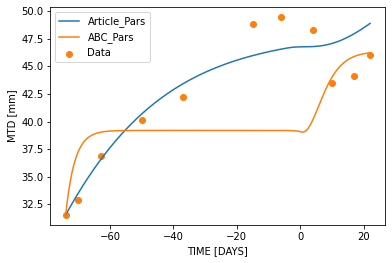

In [24]:
plt.plot(PCV_art_ind_model['t'], PCV_art_ind_model['P_sum'], color="C0", label='Article_Pars')
plt.plot(PCV_abc_ind_model['t'], PCV_abc_ind_model['P_sum'], color="C1", label='ABC_Pars')
plt.scatter(PCV_ind_patient_time, PCV_ind_patient_data, color="C1", label='Data')
plt.xlabel("TIME [DAYS]")
plt.ylabel("MTD [mm]")
plt.legend()
plt.show()

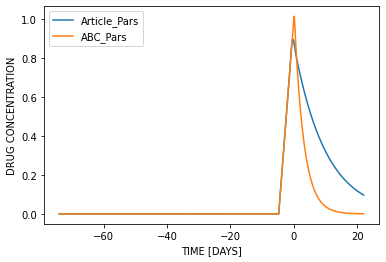

In [25]:
plt.plot(PCV_art_ind_model['t'], PCV_art_ind_model['dC'], color="C0", label='Article_Pars')
plt.plot(PCV_abc_ind_model['t'], PCV_abc_ind_model['dC'], color="C1", label='ABC_Pars')
plt.xlabel("TIME [DAYS]")
plt.ylabel("DRUG CONCENTRATION")
plt.legend()
plt.show()

In [26]:
show_art_abc_posterior(h)


    		ARTICLE: 	 ABC-SMC
    K: 		 100 		 131.86860626514945
    KDE: 	 0.1 		 0.33443271252967444
    delta_QP: 	 0.01 		 0.06772327898861286
    gamma_P: 	 0.3 		 0.723940436702055
    gamma_Q: 	 0.3 		 0.2570352552377586
    k_P_Q: 	 0.1 		 0.7385914097285068
    k_QP_P: 	 0.05 		 0.31323273986681477
    lambda_P: 	 0.121 		 0.5536528912881948
    


### Asymilacja modelu indywidualnego do wszystkich pacjentów PCV

In [117]:
def get_data_for_groups(groups):
    measurements = []
    times = []
    for group_n in groups:
        group_data = data[group_n]
        for patient_n in range(int(group_data.shape[1]/2)):
            ind_patient_data = data[group_n][patient_n*2+1][data[group_n][patient_n*2+1].notnull()].values
            ind_patient_time = data[group_n][patient_n*2][data[group_n][patient_n*2].notnull()].values
            measurements.append(ind_patient_data)   
            times.append(ind_patient_time)
    return measurements, times

def train_ind_model(measurement, time):
    P_SUM_0 = measurement[0]
    C_0 = 0
    QP_0 = 0
    P_0 = P_SUM_0 / 5
    Q_0 = P_SUM_0 - P_0 - QP_0

    y0 = np.array([P_SUM_0, C_0, P_0, Q_0, QP_0])

    parameter_prior = Distribution(
        KDE=RV("uniform", 0.0, 1),
        lambda_P=RV("uniform", 0.0, 1),
        gamma_P=RV("uniform", 0.0, 1),
        gamma_Q=RV("uniform", 0.0, 1),
        k_QP_P=RV("uniform", 0.0, 0.5),
        delta_QP=RV("uniform", 0.0, 1),
        k_P_Q=RV("uniform", 0.0, 1),
        K=RV("uniform", 10, 200)
    )

    ind_model = lambda pars: individual_model(t=time, y0=y0, pars=pars)
    ind_abc = ABCSMC(
        models=ind_model,
        parameter_priors=parameter_prior,
        distance_function=distance,
        population_size=10,
        transitions=LocalTransition(k_fraction=.3),
        eps=MedianEpsilon(20, median_multiplier=0.7)
    )

    ind_abc.new(db_path, {'P_sum': measurement, 't': time})

    h = ind_abc.run(minimum_epsilon=5, max_nr_populations=3)
    return get_posterior(h)



In [124]:
TIMEOUT = 30

def worker(m, t, posteriors):
    post = train_ind_model(m, t)
    posteriors.append(post)

def get_mean_parameters_for_groups(groups):
    measurements, times = get_data_for_groups(groups)

    manager = multiprocessing.Manager()
    posteriors = manager.list()
    patient_spec = []

    for m, t in zip(measurements, times):
        p = multiprocessing.Process(target=worker, args=(m, t, posteriors))
        p.start()
        p.join(TIMEOUT)

        if p.is_alive():
            p.terminate()
            p.join()
            print('\n\nKILLED\n\n')
        else:
            p.join()
            patient_spec.append((m, t, posteriors[-1]))
    return np.mean(posteriors, axis=0), np.std(posteriors, axis=0), patient_spec




In [125]:
PCV_groups = [0 1, 2]
PCV_mean_parameters, PCV_std_parameters, PCV_patients_spec = get_mean_parameters_for_groups(PCV_groups)

INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=123, start_time=2021-01-24 13:58:54.656192, end_time=None)>
INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 17 = 5.8824e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 7.118598442758551.
INFO:ABC:Acceptance rate: 10 / 84 = 1.1905e-01, ESS=6.2769e+00.
INFO:ABC:t: 2, eps: 4.029261504934401.




KILLED




INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=124, start_time=2021-01-24 13:59:24.794722, end_time=None)>
INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 16 = 6.2500e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 8.442598802460155.
INFO:ABC:Acceptance rate: 10 / 33 = 3.0303e-01, ESS=2.3853e+00.
INFO:ABC:t: 2, eps: 4.865224265306785.
INFO:ABC:Acceptance rate: 10 / 50 = 2.0000e-01, ESS=1.0555e+00.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=124, start_time=2021-01-24 13:59:24.794722, end_time=2021-01-24 13:59:37.547472)>
INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=125, start_time=2021-01-24 13:59:37.990838, end_time=None)>
INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 15 = 6.6667e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 8.163803858786105.
INFO:ABC:Acceptance rate: 10 / 39 = 2.5641e-01, ESS=5.8679e+00.
INFO:ABC:t: 2, eps: 4.6116432061214985.
INFO:ABC:Acceptance rat



KILLED




INFO:Sampler:Parallelizing the sampling on 2 cores.
INFO:History:Start <ABCSMC(id=127, start_time=2021-01-24 14:00:25.512217, end_time=None)>
INFO:ABC:t: 0, eps: 20.
INFO:ABC:Acceptance rate: 10 / 13 = 7.6923e-01, ESS=1.0000e+01.
INFO:ABC:t: 1, eps: 6.515903111034013.
INFO:ABC:Acceptance rate: 10 / 22 = 4.5455e-01, ESS=4.1797e+00.
INFO:ABC:t: 2, eps: 3.2996912386772292.
INFO:ABC:Acceptance rate: 10 / 33 = 3.0303e-01, ESS=3.8253e+00.
INFO:pyabc.util:Stopping: maximum number of generations.
INFO:History:Done <ABCSMC(id=127, start_time=2021-01-24 14:00:25.512217, end_time=2021-01-24 14:00:32.964014)>


In [113]:
PCV_art_pars = [K_art, KDE_art, delta_QP_art, gamma_P_art, gamma_Q_art, k_P_Q_art, k_QP_P_art, lambda_P_art]
show_article_comparison(PCV_art_pars, PCV_mean_parameters,'PCV')


    	GROUP: PCV

    		ARTICLE: 	 ABC-SMC
    K: 		 100 		 96.66140031041823
    KDE: 	 0.1 		 0.25187096158873706
    delta_QP: 	 0.01 		 0.26062729075067265
    gamma_P: 	 0.3 		 0.5451397521949711
    gamma_Q: 	 0.3 		 0.40974908553602873
    k_P_Q: 	 0.1 		 0.523938226435063
    k_QP_P: 	 0.05 		 0.2959866044625057
    lambda_P: 	 0.121 		 0.5541228375198988
    


(array([31.55059456, 32.88196811, 36.87608877, 40.13055745, 42.20158297,
        48.85845073, 49.45017231, 48.26672915, 43.53295653, 44.1246781 ,
        46.04777323]),
 array([-73.85371483, -69.94355467, -63.20938995, -49.7410605 ,
        -37.35888666, -15.20131242,  -6.07760538,   3.91502614,
         10.21472862,  16.94889334,  21.9452091 ]),
 array([109.4187964 ,   0.68489942,   0.85732058,   0.97472515,
          0.44904386,   0.7058396 ,   0.34094169,   0.68675116]))